# Train a JointVAE model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import torch

use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # change to your device

#### Prepare data list

In [4]:
!ls data

dress_dresslen_train_test_splits.json	dress_sleeve_train_test_splits.json
dress_sleevelen_train_test_splits.json	loadable_women_primary_dress.csv


#### dress sleeve data

In [5]:
import json
with open("./data/dress_sleeve_train_test_splits.json", "r") as infile:
    data_dict = json.load(infile)
    
data_dict.keys()

dict_keys(['X_train_1', 'y_train_1', 'X_test_1', 'y_test_1', 'X_train_2', 'y_train_2', 'X_test_2', 'y_test_2', 'X_train_3', 'y_train_3', 'X_test_3', 'y_test_3', 'X_train_4', 'y_train_4', 'X_test_4', 'y_test_4', 'X_train_5', 'y_train_5', 'X_test_5', 'y_test_5', 'X_train_6', 'y_train_6', 'X_test_6', 'y_test_6', 'X_train_7', 'y_train_7', 'X_test_7', 'y_test_7', 'X_train_8', 'y_train_8', 'X_test_8', 'y_test_8', 'X_train_9', 'y_train_9', 'X_test_9', 'y_test_9', 'X_train_10', 'y_train_10', 'X_test_10', 'y_test_10'])

In [14]:
image_paths_train = []
image_paths_test = []

root_data_dir = "/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables"

for key, val in data_dict.items():
    if 'X_train' in key:
        image_paths_train.extend([root_data_dir + imgpath for imgpath in val])
    elif 'X_test' in key:
        image_paths_test.extend([root_data_dir + imgpath for imgpath in val])

print(f"Number of train image paths: {len(image_paths_train):,d}")
print(f"Number of test image paths: {len(image_paths_test):,d}")
print()
print("Sample paths:")
print(image_paths_train[0])
print(image_paths_train[-1])
print(image_paths_test[0])
print(image_paths_test[-1])

Number of train image paths: 207,603
Number of test image paths: 23,067

Sample paths:
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/8/2893552_3773662.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/7/2713940_3640098.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/8/2856150_3749586.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/3/0/3058817_8191784.jpg


#### loadable dresses data

### Create data loaders

In [15]:
from torchvision import transforms
from utils.dataloader_tools import get_imagelist_dataloader, ImageListDataset

BATCH_SIZE = 64

composed = transforms.Compose([transforms.CenterCrop((256,256)),transforms.Resize((256,256)),transforms.ToTensor()])

# convert rgb is for the cv2 loaded images that I've got in this dir
train_dataset = ImageListDataset(image_paths_train, cut_from='top', cut_amount=256, transform=composed, 
                                 convert_rgb=False, error_handling=True)
test_dataset = ImageListDataset(image_paths_test, cut_from='top', cut_amount=256, transform=composed, 
                                convert_rgb=False, error_handling=True)

train_loader = get_imagelist_dataloader(batch_size=BATCH_SIZE, dataset_object=train_dataset)
test_loader = get_imagelist_dataloader(batch_size=BATCH_SIZE, dataset_object=test_dataset)

### Define latent distribution of the model

In [16]:
# Latent distribution will be joint distribution of 10 gaussian normal distributions
# and one 10 dimensional Gumbel Softmax distribution
latent_spec = {'cont': 10, 'disc': [10, 10, 10, 10]}

### Build a model

In [17]:
from jointvae.models_256_convjump1 import VAE

model = VAE(latent_spec=latent_spec, img_size=(3, 256, 256), use_cuda=use_cuda)

In [18]:
#print(model)

### Train the model

In [19]:
from torch import optim

# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4, amsgrad=True) # added amsgrad # orig lr 5e-4

In [20]:
from jointvae.training import Trainer
#from jointvae.training_debug import Trainer

# Define the capacities
# Continuous channels
cont_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0

# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity,
                 use_cuda=use_cuda)

#### Initialize visualizer

In [21]:
#from viz.visualize import Visualizer
from viz.visualize import Visualizer

viz = Visualizer(model)
viz.save_images = False # needed to add this so it returns a tensor

In [22]:
# Note this should be at least 100 epochs for proper training or more but can be less to demo

trainer.train(train_loader, epochs=135, save_training_gif=None)

0/207603	Loss: 45354.805
3200/207603	Loss: 43998.898
6400/207603	Loss: 32837.047
9600/207603	Loss: 27410.008
12800/207603	Loss: 25300.935
16000/207603	Loss: 19634.300
32000/207603	Loss: 16906.072
35200/207603	Loss: 16788.593
38400/207603	Loss: 16552.677
41600/207603	Loss: 16693.982
44800/207603	Loss: 16481.109
48000/207603	Loss: 16493.851
51200/207603	Loss: 16296.562
54400/207603	Loss: 16265.561
57600/207603	Loss: 16307.226
60800/207603	Loss: 16151.475
64000/207603	Loss: 16155.092
67200/207603	Loss: 16130.329
70400/207603	Loss: 16086.299
73600/207603	Loss: 16025.265
76800/207603	Loss: 15928.253
80000/207603	Loss: 15948.224
83200/207603	Loss: 15992.809
86400/207603	Loss: 15906.714
89600/207603	Loss: 15841.113
92800/207603	Loss: 15888.317
96000/207603	Loss: 15966.965
99200/207603	Loss: 15835.486
102400/207603	Loss: 15907.317
105600/207603	Loss: 15835.439
108800/207603	Loss: 15734.048
112000/207603	Loss: 15754.549
115200/207603	Loss: 15878.859
118400/207603	Loss: 15684.457
121600/207603	L

60800/207603	Loss: 14955.448
64000/207603	Loss: 14825.922
67200/207603	Loss: 15011.242
70400/207603	Loss: 14879.517
73600/207603	Loss: 15058.428
76800/207603	Loss: 14980.210
80000/207603	Loss: 14887.893
83200/207603	Loss: 14895.933
86400/207603	Loss: 14869.307
89600/207603	Loss: 14957.837
92800/207603	Loss: 14873.907
96000/207603	Loss: 14882.532
99200/207603	Loss: 14897.615
102400/207603	Loss: 14856.917
105600/207603	Loss: 14792.911
108800/207603	Loss: 14900.597
112000/207603	Loss: 14725.663
115200/207603	Loss: 14894.847
118400/207603	Loss: 14825.343
121600/207603	Loss: 14841.787
124800/207603	Loss: 14989.114
128000/207603	Loss: 14888.634
131200/207603	Loss: 14835.675
134400/207603	Loss: 14932.723
137600/207603	Loss: 14943.853
140800/207603	Loss: 14858.410
144000/207603	Loss: 14911.102
147200/207603	Loss: 14801.521
150400/207603	Loss: 14857.429
153600/207603	Loss: 14887.807
156800/207603	Loss: 14793.730
160000/207603	Loss: 14893.673
163200/207603	Loss: 14852.334
166400/207603	Loss: 149

108800/207603	Loss: 14627.369
112000/207603	Loss: 14528.790
115200/207603	Loss: 14616.462
118400/207603	Loss: 14609.451
121600/207603	Loss: 14583.683
124800/207603	Loss: 14703.230
128000/207603	Loss: 14626.013
131200/207603	Loss: 14682.873
134400/207603	Loss: 14516.406
137600/207603	Loss: 14573.208
140800/207603	Loss: 14581.609
144000/207603	Loss: 14543.169
147200/207603	Loss: 14587.175
150400/207603	Loss: 14664.582
153600/207603	Loss: 14741.817
156800/207603	Loss: 14653.227
160000/207603	Loss: 14675.242
163200/207603	Loss: 14572.885
166400/207603	Loss: 14614.139
169600/207603	Loss: 14623.827
172800/207603	Loss: 14665.843
176000/207603	Loss: 14727.877
179200/207603	Loss: 14611.974
182400/207603	Loss: 14586.281
185600/207603	Loss: 14665.438
188800/207603	Loss: 14677.439
192000/207603	Loss: 14543.274
195200/207603	Loss: 14676.733
198400/207603	Loss: 14658.545
201600/207603	Loss: 14537.942
204800/207603	Loss: 14658.057
Epoch: 9 Average loss: 14631.03
0/207603	Loss: 14384.416
3200/207603	L

153600/207603	Loss: 14339.807
156800/207603	Loss: 14347.875
160000/207603	Loss: 14398.109
163200/207603	Loss: 14328.410
166400/207603	Loss: 14320.917
169600/207603	Loss: 14320.174
172800/207603	Loss: 14369.683
176000/207603	Loss: 14319.482
179200/207603	Loss: 14359.970
182400/207603	Loss: 14360.424
185600/207603	Loss: 14480.082
188800/207603	Loss: 14338.800
192000/207603	Loss: 14428.053
195200/207603	Loss: 14240.693
198400/207603	Loss: 14419.649
201600/207603	Loss: 14357.730
204800/207603	Loss: 14219.513
Epoch: 13 Average loss: 14375.47
0/207603	Loss: 14713.100
3200/207603	Loss: 14226.083
6400/207603	Loss: 14340.482
9600/207603	Loss: 14392.031
12800/207603	Loss: 14307.965
16000/207603	Loss: 14273.252
19200/207603	Loss: 14459.547
22400/207603	Loss: 14262.491
25600/207603	Loss: 14418.930
28800/207603	Loss: 14182.295
32000/207603	Loss: 14247.366
35200/207603	Loss: 14471.195
38400/207603	Loss: 14297.022
41600/207603	Loss: 14288.670
44800/207603	Loss: 14302.667
48000/207603	Loss: 14298.471


198400/207603	Loss: 14331.690
201600/207603	Loss: 14260.262
204800/207603	Loss: 14403.517
Epoch: 17 Average loss: 14308.34
0/207603	Loss: 14586.625
3200/207603	Loss: 14204.298
6400/207603	Loss: 14254.278
9600/207603	Loss: 14180.443
12800/207603	Loss: 14299.306
16000/207603	Loss: 14284.865
19200/207603	Loss: 14298.142
22400/207603	Loss: 14463.644
25600/207603	Loss: 14305.655
28800/207603	Loss: 14317.944
32000/207603	Loss: 14458.424
35200/207603	Loss: 14223.749
38400/207603	Loss: 14397.658
41600/207603	Loss: 14273.035
44800/207603	Loss: 14294.317
48000/207603	Loss: 14244.691
51200/207603	Loss: 14389.149
54400/207603	Loss: 14172.984
57600/207603	Loss: 14300.917
60800/207603	Loss: 14308.602
64000/207603	Loss: 14351.566
67200/207603	Loss: 14367.165
70400/207603	Loss: 14285.040
73600/207603	Loss: 14382.259
76800/207603	Loss: 14357.812
80000/207603	Loss: 14202.352
83200/207603	Loss: 14257.586
86400/207603	Loss: 14408.944
89600/207603	Loss: 14300.057
92800/207603	Loss: 14306.027
96000/207603	L

48000/207603	Loss: 14273.088
51200/207603	Loss: 14253.494
54400/207603	Loss: 14146.043
57600/207603	Loss: 14258.358
60800/207603	Loss: 14216.582
64000/207603	Loss: 14170.301
67200/207603	Loss: 14321.054
70400/207603	Loss: 14153.780
73600/207603	Loss: 14335.776
76800/207603	Loss: 14358.833
80000/207603	Loss: 14244.692
83200/207603	Loss: 14232.440
86400/207603	Loss: 14210.591
89600/207603	Loss: 14255.596
92800/207603	Loss: 14408.236
96000/207603	Loss: 14164.486
99200/207603	Loss: 14152.760
102400/207603	Loss: 14376.557
105600/207603	Loss: 14438.652
108800/207603	Loss: 14235.623
112000/207603	Loss: 14207.921
115200/207603	Loss: 14202.590
118400/207603	Loss: 14173.981
121600/207603	Loss: 14189.997
124800/207603	Loss: 14101.507
128000/207603	Loss: 14201.321
131200/207603	Loss: 14379.926
134400/207603	Loss: 14317.365
137600/207603	Loss: 14208.835
140800/207603	Loss: 14310.965
144000/207603	Loss: 14283.187
147200/207603	Loss: 14261.191
150400/207603	Loss: 14362.528
153600/207603	Loss: 14237.5

96000/207603	Loss: 14277.204
99200/207603	Loss: 14257.059
102400/207603	Loss: 14328.029
105600/207603	Loss: 14219.486
108800/207603	Loss: 14277.366
112000/207603	Loss: 14130.297
115200/207603	Loss: 14170.298
118400/207603	Loss: 14347.114
121600/207603	Loss: 14185.206
124800/207603	Loss: 14163.771
128000/207603	Loss: 14196.362
131200/207603	Loss: 14160.470
134400/207603	Loss: 14163.230
137600/207603	Loss: 14228.928
140800/207603	Loss: 14166.119
144000/207603	Loss: 14187.419
147200/207603	Loss: 14282.752
150400/207603	Loss: 14264.093
153600/207603	Loss: 14200.831
156800/207603	Loss: 14211.334
160000/207603	Loss: 14343.073
163200/207603	Loss: 14281.257
166400/207603	Loss: 14252.402
169600/207603	Loss: 14317.780
172800/207603	Loss: 14130.690
176000/207603	Loss: 14315.765
179200/207603	Loss: 14253.968
182400/207603	Loss: 14126.101
185600/207603	Loss: 14203.691
188800/207603	Loss: 14227.341
192000/207603	Loss: 14244.014
195200/207603	Loss: 14162.284
198400/207603	Loss: 14249.267
201600/20760

140800/207603	Loss: 14345.395
144000/207603	Loss: 14160.131
147200/207603	Loss: 14172.354
150400/207603	Loss: 14040.339
153600/207603	Loss: 14263.530
156800/207603	Loss: 14126.138
160000/207603	Loss: 14222.883
163200/207603	Loss: 14229.631
166400/207603	Loss: 14306.385
169600/207603	Loss: 14100.708
172800/207603	Loss: 14152.419
176000/207603	Loss: 14183.671
179200/207603	Loss: 14307.860
182400/207603	Loss: 14258.251
185600/207603	Loss: 14278.732
188800/207603	Loss: 14127.649
192000/207603	Loss: 14209.742
195200/207603	Loss: 14273.091
198400/207603	Loss: 14220.739
201600/207603	Loss: 14125.287
204800/207603	Loss: 14265.521
Epoch: 30 Average loss: 14200.60
0/207603	Loss: 15007.978
3200/207603	Loss: 14057.678
6400/207603	Loss: 14266.117
9600/207603	Loss: 14143.802
12800/207603	Loss: 14259.760
16000/207603	Loss: 14157.274
19200/207603	Loss: 14179.565
22400/207603	Loss: 14140.027
25600/207603	Loss: 14217.116
28800/207603	Loss: 14087.860
32000/207603	Loss: 14220.620
35200/207603	Loss: 14177.

185600/207603	Loss: 14236.507
188800/207603	Loss: 14186.531
192000/207603	Loss: 14214.394
195200/207603	Loss: 14128.219
198400/207603	Loss: 14103.121
201600/207603	Loss: 14160.410
204800/207603	Loss: 14168.425
Epoch: 34 Average loss: 14179.42
0/207603	Loss: 14036.702
3200/207603	Loss: 14129.382
6400/207603	Loss: 14158.586
9600/207603	Loss: 14009.058
12800/207603	Loss: 14206.613
16000/207603	Loss: 14212.258
19200/207603	Loss: 14143.178
22400/207603	Loss: 14135.318
25600/207603	Loss: 14153.974
28800/207603	Loss: 14165.607
38400/207603	Loss: 14080.057
41600/207603	Loss: 14173.990
44800/207603	Loss: 14183.528
48000/207603	Loss: 14193.613
51200/207603	Loss: 14258.531
54400/207603	Loss: 14030.021
57600/207603	Loss: 14218.916
60800/207603	Loss: 14239.721
64000/207603	Loss: 14216.110
67200/207603	Loss: 14106.789
70400/207603	Loss: 14179.291
73600/207603	Loss: 14197.021
76800/207603	Loss: 14286.885
80000/207603	Loss: 14173.692
83200/207603	Loss: 14307.547
86400/207603	Loss: 14181.663
89600/2076

28800/207603	Loss: 14140.243
32000/207603	Loss: 14194.811
35200/207603	Loss: 14178.131
38400/207603	Loss: 14316.541
41600/207603	Loss: 14246.882
44800/207603	Loss: 14140.569
48000/207603	Loss: 14238.454
51200/207603	Loss: 14118.716
54400/207603	Loss: 14162.578
57600/207603	Loss: 14158.070
60800/207603	Loss: 14126.071
64000/207603	Loss: 14171.694
67200/207603	Loss: 14216.063
70400/207603	Loss: 14135.279
73600/207603	Loss: 14090.884
76800/207603	Loss: 14130.350
80000/207603	Loss: 14102.294
83200/207603	Loss: 14125.303
86400/207603	Loss: 14223.674
89600/207603	Loss: 14107.403
92800/207603	Loss: 14109.433
96000/207603	Loss: 14184.308
99200/207603	Loss: 14228.521
102400/207603	Loss: 14262.077
105600/207603	Loss: 14048.380
108800/207603	Loss: 14107.217
112000/207603	Loss: 14145.778
115200/207603	Loss: 14160.739
118400/207603	Loss: 14102.725
121600/207603	Loss: 14221.376
124800/207603	Loss: 14131.895
128000/207603	Loss: 14144.535
131200/207603	Loss: 14193.692
134400/207603	Loss: 14116.461
137

76800/207603	Loss: 14135.933
80000/207603	Loss: 14097.050
83200/207603	Loss: 14201.118
86400/207603	Loss: 14128.256
89600/207603	Loss: 14016.702
92800/207603	Loss: 14234.806
96000/207603	Loss: 14106.992
99200/207603	Loss: 14154.018
102400/207603	Loss: 14097.956
105600/207603	Loss: 14191.511
108800/207603	Loss: 14197.879
112000/207603	Loss: 14152.248
115200/207603	Loss: 14263.762
118400/207603	Loss: 14099.539
121600/207603	Loss: 14179.337
124800/207603	Loss: 14154.293
128000/207603	Loss: 14166.020
131200/207603	Loss: 14083.230
134400/207603	Loss: 14131.359
137600/207603	Loss: 14129.685
140800/207603	Loss: 14123.707
144000/207603	Loss: 14115.636
147200/207603	Loss: 14074.917
150400/207603	Loss: 14230.881
153600/207603	Loss: 14152.482
156800/207603	Loss: 14199.523
160000/207603	Loss: 14065.744
163200/207603	Loss: 14198.592
166400/207603	Loss: 14210.527
169600/207603	Loss: 14023.307
172800/207603	Loss: 14085.823
176000/207603	Loss: 14088.628
179200/207603	Loss: 14186.526
182400/207603	Loss

124800/207603	Loss: 14177.209
128000/207603	Loss: 14188.891
131200/207603	Loss: 14063.016
134400/207603	Loss: 14366.410
137600/207603	Loss: 14232.754
140800/207603	Loss: 14067.256
144000/207603	Loss: 14034.161
147200/207603	Loss: 14137.685
150400/207603	Loss: 14009.357
153600/207603	Loss: 14050.154
156800/207603	Loss: 14042.919
160000/207603	Loss: 14086.789
163200/207603	Loss: 14138.934
166400/207603	Loss: 14096.412
169600/207603	Loss: 14112.710
172800/207603	Loss: 14087.569
176000/207603	Loss: 14229.224
179200/207603	Loss: 14113.417
182400/207603	Loss: 14064.703
185600/207603	Loss: 14115.060
188800/207603	Loss: 14139.249
192000/207603	Loss: 14346.491
195200/207603	Loss: 14079.531
198400/207603	Loss: 14056.164
201600/207603	Loss: 14110.381
204800/207603	Loss: 14024.334
Epoch: 47 Average loss: 14131.60
0/207603	Loss: 14141.574
3200/207603	Loss: 14101.893
6400/207603	Loss: 14097.463
9600/207603	Loss: 14157.672
12800/207603	Loss: 14104.838
16000/207603	Loss: 14004.956
19200/207603	Loss: 1

169600/207603	Loss: 14239.940
172800/207603	Loss: 14158.826
176000/207603	Loss: 14120.094
179200/207603	Loss: 14163.905
182400/207603	Loss: 14069.555
185600/207603	Loss: 14194.153
188800/207603	Loss: 14081.224
192000/207603	Loss: 14047.556
195200/207603	Loss: 14269.199
198400/207603	Loss: 14161.396
201600/207603	Loss: 14058.820
204800/207603	Loss: 14103.464
Epoch: 51 Average loss: 14119.53
0/207603	Loss: 14591.005
3200/207603	Loss: 14048.338
6400/207603	Loss: 14099.331
9600/207603	Loss: 14130.055
12800/207603	Loss: 14189.238
16000/207603	Loss: 14161.917
19200/207603	Loss: 14120.678
22400/207603	Loss: 14061.233
25600/207603	Loss: 14054.184
28800/207603	Loss: 14105.262
32000/207603	Loss: 14006.927
35200/207603	Loss: 14128.853
38400/207603	Loss: 14077.419
41600/207603	Loss: 14165.805
44800/207603	Loss: 14056.446
48000/207603	Loss: 14052.344
51200/207603	Loss: 14228.139
54400/207603	Loss: 14167.962
57600/207603	Loss: 14242.258
60800/207603	Loss: 14089.707
64000/207603	Loss: 13964.929
67200

3200/207603	Loss: 14082.889
6400/207603	Loss: 14029.162
9600/207603	Loss: 14072.228
12800/207603	Loss: 14081.058
16000/207603	Loss: 14137.663
19200/207603	Loss: 14094.922
22400/207603	Loss: 14125.861
25600/207603	Loss: 14143.230
28800/207603	Loss: 14102.243
32000/207603	Loss: 14071.927
35200/207603	Loss: 14073.423
38400/207603	Loss: 14091.677
41600/207603	Loss: 14143.167
44800/207603	Loss: 14071.121
48000/207603	Loss: 14027.676
51200/207603	Loss: 14117.150
54400/207603	Loss: 14071.296
57600/207603	Loss: 14143.117
60800/207603	Loss: 14101.845
64000/207603	Loss: 14169.749
67200/207603	Loss: 14051.376
70400/207603	Loss: 13960.298
73600/207603	Loss: 14075.493
76800/207603	Loss: 14055.412
80000/207603	Loss: 14030.261
83200/207603	Loss: 14158.612
86400/207603	Loss: 14102.140
89600/207603	Loss: 14027.518
92800/207603	Loss: 14253.159
96000/207603	Loss: 14101.336
99200/207603	Loss: 14081.825
102400/207603	Loss: 14087.337
105600/207603	Loss: 14079.939
108800/207603	Loss: 14003.672
112000/207603	

57600/207603	Loss: 14097.143
60800/207603	Loss: 14088.568
64000/207603	Loss: 14068.122
67200/207603	Loss: 14062.192
70400/207603	Loss: 14023.989
73600/207603	Loss: 14171.021
76800/207603	Loss: 14065.261
80000/207603	Loss: 13777.545
83200/207603	Loss: 14149.964
86400/207603	Loss: 14064.234
89600/207603	Loss: 14049.591
92800/207603	Loss: 14116.792
96000/207603	Loss: 14139.608
99200/207603	Loss: 14166.555
102400/207603	Loss: 13993.504
105600/207603	Loss: 14091.306
108800/207603	Loss: 14091.646
112000/207603	Loss: 14081.847
115200/207603	Loss: 14111.181
118400/207603	Loss: 14107.143
121600/207603	Loss: 14044.051
124800/207603	Loss: 14043.041
128000/207603	Loss: 14072.937
131200/207603	Loss: 14044.867
134400/207603	Loss: 14138.528
137600/207603	Loss: 14073.175
140800/207603	Loss: 14048.745
144000/207603	Loss: 14065.297
147200/207603	Loss: 14190.604
150400/207603	Loss: 14212.230
153600/207603	Loss: 14076.411
156800/207603	Loss: 14175.760
160000/207603	Loss: 13968.983
163200/207603	Loss: 1413

105600/207603	Loss: 13973.377
108800/207603	Loss: 14074.604
112000/207603	Loss: 14205.506
115200/207603	Loss: 14144.187
118400/207603	Loss: 13978.442
128000/207603	Loss: 13926.992
131200/207603	Loss: 14120.792
134400/207603	Loss: 14075.765
137600/207603	Loss: 14020.390
140800/207603	Loss: 14207.676
144000/207603	Loss: 14132.186
147200/207603	Loss: 14075.525
150400/207603	Loss: 14042.387
153600/207603	Loss: 14073.881
156800/207603	Loss: 14290.592
160000/207603	Loss: 14115.489
163200/207603	Loss: 14030.406
166400/207603	Loss: 14058.667
169600/207603	Loss: 14160.623
172800/207603	Loss: 14130.709
176000/207603	Loss: 14130.511
179200/207603	Loss: 14124.339
182400/207603	Loss: 14112.263
185600/207603	Loss: 14157.504
188800/207603	Loss: 14007.636
192000/207603	Loss: 14039.020
195200/207603	Loss: 14163.696
198400/207603	Loss: 14060.888
201600/207603	Loss: 14025.477
204800/207603	Loss: 13977.259
Epoch: 64 Average loss: 14084.28
0/207603	Loss: 13839.618
3200/207603	Loss: 14145.236
6400/207603	Lo

156800/207603	Loss: 14119.761
160000/207603	Loss: 13962.443
163200/207603	Loss: 14036.003
166400/207603	Loss: 14083.572
169600/207603	Loss: 14046.236
172800/207603	Loss: 14092.169
176000/207603	Loss: 14039.815
179200/207603	Loss: 14077.405
182400/207603	Loss: 14107.417
185600/207603	Loss: 14103.340
188800/207603	Loss: 14105.533
192000/207603	Loss: 14053.774
195200/207603	Loss: 14030.700
198400/207603	Loss: 14005.362
201600/207603	Loss: 14173.827
204800/207603	Loss: 14127.313
Epoch: 68 Average loss: 14075.41
0/207603	Loss: 14146.197
3200/207603	Loss: 14107.618
6400/207603	Loss: 14028.735
9600/207603	Loss: 14069.838
12800/207603	Loss: 14160.399
16000/207603	Loss: 14027.366
19200/207603	Loss: 14042.264
22400/207603	Loss: 13998.234
25600/207603	Loss: 14009.450
28800/207603	Loss: 14138.945
32000/207603	Loss: 14127.374
35200/207603	Loss: 14162.876
38400/207603	Loss: 14085.135
41600/207603	Loss: 14055.353
44800/207603	Loss: 14043.230
48000/207603	Loss: 14257.766
51200/207603	Loss: 14146.574
5

201600/207603	Loss: 14011.977
204800/207603	Loss: 14207.841
Epoch: 72 Average loss: 14067.78
0/207603	Loss: 14698.799
3200/207603	Loss: 14013.794
6400/207603	Loss: 14013.091
9600/207603	Loss: 13912.905
12800/207603	Loss: 14036.826
16000/207603	Loss: 14144.167
19200/207603	Loss: 14105.622
22400/207603	Loss: 13989.876
25600/207603	Loss: 14009.290
28800/207603	Loss: 14189.009
32000/207603	Loss: 14066.875
35200/207603	Loss: 14096.590
38400/207603	Loss: 14088.371
41600/207603	Loss: 14028.637
44800/207603	Loss: 14216.834
48000/207603	Loss: 14052.491
51200/207603	Loss: 14050.172
54400/207603	Loss: 14081.834
57600/207603	Loss: 14012.562
60800/207603	Loss: 14050.439
64000/207603	Loss: 14062.211
67200/207603	Loss: 14026.404
70400/207603	Loss: 14177.339
73600/207603	Loss: 14072.392
76800/207603	Loss: 14057.479
80000/207603	Loss: 14023.813
83200/207603	Loss: 14137.081
86400/207603	Loss: 14022.147
89600/207603	Loss: 14136.286
92800/207603	Loss: 13996.518
96000/207603	Loss: 14051.441
99200/207603	Lo

44800/207603	Loss: 14000.047
48000/207603	Loss: 14009.977
51200/207603	Loss: 13990.349
54400/207603	Loss: 14111.169
57600/207603	Loss: 14147.587
60800/207603	Loss: 14002.927
64000/207603	Loss: 14045.765
67200/207603	Loss: 14111.608
70400/207603	Loss: 14071.656
73600/207603	Loss: 14004.231
76800/207603	Loss: 14081.676
80000/207603	Loss: 14069.024
83200/207603	Loss: 14046.990
86400/207603	Loss: 14108.587
89600/207603	Loss: 13941.154
92800/207603	Loss: 14106.340
96000/207603	Loss: 14079.476
99200/207603	Loss: 14064.275
102400/207603	Loss: 13945.376
105600/207603	Loss: 13997.836
108800/207603	Loss: 14030.459
112000/207603	Loss: 14112.129
115200/207603	Loss: 14099.647
118400/207603	Loss: 14021.008
121600/207603	Loss: 14095.550
124800/207603	Loss: 13971.135
128000/207603	Loss: 14047.990
131200/207603	Loss: 14177.655
134400/207603	Loss: 14060.391
137600/207603	Loss: 13978.616
140800/207603	Loss: 14073.601
144000/207603	Loss: 14063.093
147200/207603	Loss: 14072.918
150400/207603	Loss: 14075.26

92800/207603	Loss: 14066.678
96000/207603	Loss: 14197.440
99200/207603	Loss: 14066.555
102400/207603	Loss: 13941.143
105600/207603	Loss: 13963.844
108800/207603	Loss: 13971.758
112000/207603	Loss: 14090.842
115200/207603	Loss: 14097.570
118400/207603	Loss: 14079.940
121600/207603	Loss: 13976.865
124800/207603	Loss: 13928.932
128000/207603	Loss: 14180.737
131200/207603	Loss: 13949.839
134400/207603	Loss: 14058.239
137600/207603	Loss: 14048.093
140800/207603	Loss: 14033.699
144000/207603	Loss: 13849.940
147200/207603	Loss: 14127.947
150400/207603	Loss: 14013.153
153600/207603	Loss: 14125.757
156800/207603	Loss: 14072.388
160000/207603	Loss: 14156.226
163200/207603	Loss: 13965.323
166400/207603	Loss: 14064.130
169600/207603	Loss: 14010.341
172800/207603	Loss: 14086.921
176000/207603	Loss: 14085.993
179200/207603	Loss: 14127.912
182400/207603	Loss: 14060.420
185600/207603	Loss: 14054.129
188800/207603	Loss: 14056.684
192000/207603	Loss: 13983.398
195200/207603	Loss: 14077.270
198400/207603

137600/207603	Loss: 14122.778
140800/207603	Loss: 14096.166
144000/207603	Loss: 14044.480
147200/207603	Loss: 14045.743
150400/207603	Loss: 13980.797
153600/207603	Loss: 14063.040
156800/207603	Loss: 14038.907
160000/207603	Loss: 14148.927
163200/207603	Loss: 14072.471
166400/207603	Loss: 14007.891
169600/207603	Loss: 14079.376
172800/207603	Loss: 14122.974
176000/207603	Loss: 14051.860
179200/207603	Loss: 14043.182
182400/207603	Loss: 14107.966
185600/207603	Loss: 14021.548
188800/207603	Loss: 14081.356
192000/207603	Loss: 14027.409
195200/207603	Loss: 14069.357
198400/207603	Loss: 14057.685
201600/207603	Loss: 14044.932
204800/207603	Loss: 14119.622
Epoch: 85 Average loss: 14045.44
0/207603	Loss: 14264.512
3200/207603	Loss: 13968.173
6400/207603	Loss: 14094.463
9600/207603	Loss: 13958.504
12800/207603	Loss: 13923.540
16000/207603	Loss: 13946.523
19200/207603	Loss: 14100.274
22400/207603	Loss: 14041.632
25600/207603	Loss: 13976.583
28800/207603	Loss: 14079.822
32000/207603	Loss: 14004

188800/207603	Loss: 14040.753
192000/207603	Loss: 14010.382
195200/207603	Loss: 14000.600
198400/207603	Loss: 14029.538
201600/207603	Loss: 14095.900
204800/207603	Loss: 14029.796
Epoch: 89 Average loss: 14039.28
0/207603	Loss: 13760.610
3200/207603	Loss: 14046.367
6400/207603	Loss: 14078.831
9600/207603	Loss: 13893.916
12800/207603	Loss: 14088.443
16000/207603	Loss: 14094.882
19200/207603	Loss: 13962.559
22400/207603	Loss: 13867.665
25600/207603	Loss: 13945.856
28800/207603	Loss: 13996.154
32000/207603	Loss: 14002.734
35200/207603	Loss: 14082.848
38400/207603	Loss: 14042.223
41600/207603	Loss: 14065.405
44800/207603	Loss: 14018.156
48000/207603	Loss: 13985.404
51200/207603	Loss: 14074.913
54400/207603	Loss: 14133.147
57600/207603	Loss: 13984.793
60800/207603	Loss: 14033.170
64000/207603	Loss: 13989.674
67200/207603	Loss: 14022.916
70400/207603	Loss: 14136.112
73600/207603	Loss: 14094.752
76800/207603	Loss: 14079.654
80000/207603	Loss: 14007.128
83200/207603	Loss: 14015.227
86400/20760

25600/207603	Loss: 14000.271
28800/207603	Loss: 13955.502
32000/207603	Loss: 13989.655
35200/207603	Loss: 14047.654
38400/207603	Loss: 14080.491
41600/207603	Loss: 14090.641
44800/207603	Loss: 14060.410
48000/207603	Loss: 14054.564
51200/207603	Loss: 14130.066
54400/207603	Loss: 13998.568
57600/207603	Loss: 13869.708
60800/207603	Loss: 14020.461
64000/207603	Loss: 13979.362
67200/207603	Loss: 14192.092
70400/207603	Loss: 14001.965
73600/207603	Loss: 14014.361
76800/207603	Loss: 14033.656
80000/207603	Loss: 13964.114
83200/207603	Loss: 14062.602
86400/207603	Loss: 13996.630
89600/207603	Loss: 14039.896
92800/207603	Loss: 13871.209
96000/207603	Loss: 13989.993
99200/207603	Loss: 14046.162
102400/207603	Loss: 13902.943
105600/207603	Loss: 13987.323
108800/207603	Loss: 14138.091
112000/207603	Loss: 13950.075
115200/207603	Loss: 14008.242
118400/207603	Loss: 13994.157
121600/207603	Loss: 14089.076
124800/207603	Loss: 14068.575
128000/207603	Loss: 14224.615
131200/207603	Loss: 14052.197
1344

73600/207603	Loss: 14023.301
76800/207603	Loss: 14004.494
80000/207603	Loss: 14137.478
83200/207603	Loss: 14092.316
86400/207603	Loss: 14116.596
89600/207603	Loss: 14031.105
92800/207603	Loss: 14046.879
96000/207603	Loss: 14040.458
99200/207603	Loss: 14062.050
102400/207603	Loss: 13968.270
105600/207603	Loss: 13935.361
108800/207603	Loss: 13933.008
112000/207603	Loss: 14053.214
115200/207603	Loss: 14027.753
118400/207603	Loss: 14018.631
121600/207603	Loss: 13883.777
124800/207603	Loss: 13989.563
128000/207603	Loss: 13949.305
131200/207603	Loss: 14011.194
134400/207603	Loss: 13939.443
137600/207603	Loss: 14043.048
140800/207603	Loss: 14114.183
144000/207603	Loss: 14091.382
147200/207603	Loss: 14040.100
150400/207603	Loss: 14091.203
153600/207603	Loss: 13995.244
156800/207603	Loss: 14018.608
160000/207603	Loss: 14017.206
163200/207603	Loss: 14077.788
166400/207603	Loss: 14070.986
169600/207603	Loss: 14150.134
172800/207603	Loss: 14116.522
176000/207603	Loss: 14113.520
179200/207603	Loss:

121600/207603	Loss: 13952.153
124800/207603	Loss: 13991.852
128000/207603	Loss: 14086.023
131200/207603	Loss: 14002.068
134400/207603	Loss: 14157.185
137600/207603	Loss: 14054.574
140800/207603	Loss: 14056.975
144000/207603	Loss: 14162.383
147200/207603	Loss: 14080.517
150400/207603	Loss: 13983.428
153600/207603	Loss: 14072.386
156800/207603	Loss: 13961.522
160000/207603	Loss: 14008.526
163200/207603	Loss: 14035.342
166400/207603	Loss: 14019.371
169600/207603	Loss: 14111.046
172800/207603	Loss: 14009.031
176000/207603	Loss: 13997.775
179200/207603	Loss: 14007.706
182400/207603	Loss: 14128.426
185600/207603	Loss: 14001.825
188800/207603	Loss: 13991.017
192000/207603	Loss: 14015.334
195200/207603	Loss: 13961.527
198400/207603	Loss: 13992.545
201600/207603	Loss: 14019.286
204800/207603	Loss: 13877.581
Epoch: 102 Average loss: 14022.35
0/207603	Loss: 14222.262
3200/207603	Loss: 13918.865
6400/207603	Loss: 14102.985
9600/207603	Loss: 14080.368
12800/207603	Loss: 14001.465
16000/207603	Loss:

166400/207603	Loss: 14003.173
169600/207603	Loss: 13948.817
172800/207603	Loss: 13986.004
176000/207603	Loss: 13901.271
179200/207603	Loss: 14031.399
182400/207603	Loss: 13967.219
185600/207603	Loss: 13931.870
188800/207603	Loss: 13983.628
192000/207603	Loss: 14021.959
195200/207603	Loss: 14031.000
198400/207603	Loss: 14068.821
201600/207603	Loss: 14134.384
204800/207603	Loss: 13951.963
Epoch: 106 Average loss: 14020.26
0/207603	Loss: 14364.068
3200/207603	Loss: 14052.385
6400/207603	Loss: 13980.342
9600/207603	Loss: 14137.009
12800/207603	Loss: 13983.766
16000/207603	Loss: 14021.887
19200/207603	Loss: 14016.238
22400/207603	Loss: 13937.700
25600/207603	Loss: 14030.555
28800/207603	Loss: 14029.542
32000/207603	Loss: 13977.860
35200/207603	Loss: 14140.733
38400/207603	Loss: 14108.573
41600/207603	Loss: 14053.902
44800/207603	Loss: 13955.000
48000/207603	Loss: 13994.660
51200/207603	Loss: 13905.733
54400/207603	Loss: 13963.376
57600/207603	Loss: 14069.666
60800/207603	Loss: 13873.624
640

0/207603	Loss: 13625.242
3200/207603	Loss: 13970.833
6400/207603	Loss: 13986.321
9600/207603	Loss: 14003.774
12800/207603	Loss: 14093.749
16000/207603	Loss: 13985.917
19200/207603	Loss: 13918.549
22400/207603	Loss: 14034.618
25600/207603	Loss: 13904.372
28800/207603	Loss: 14028.259
32000/207603	Loss: 13985.374
35200/207603	Loss: 14107.316
38400/207603	Loss: 13968.157
41600/207603	Loss: 14134.334
44800/207603	Loss: 14067.099
48000/207603	Loss: 13994.435
51200/207603	Loss: 14038.642
54400/207603	Loss: 14033.142
57600/207603	Loss: 14030.162
60800/207603	Loss: 13993.115
64000/207603	Loss: 14023.353
67200/207603	Loss: 14089.435
70400/207603	Loss: 14099.101
73600/207603	Loss: 13903.450
76800/207603	Loss: 14155.278
80000/207603	Loss: 13914.453
83200/207603	Loss: 14052.571
86400/207603	Loss: 13915.130
89600/207603	Loss: 14008.955
92800/207603	Loss: 14039.910
96000/207603	Loss: 14088.998
99200/207603	Loss: 13979.008
102400/207603	Loss: 13993.178
105600/207603	Loss: 14078.447
108800/207603	Loss:

48000/207603	Loss: 14082.977
51200/207603	Loss: 14170.233
54400/207603	Loss: 13999.380
57600/207603	Loss: 14045.759
60800/207603	Loss: 13942.130
64000/207603	Loss: 13986.440
67200/207603	Loss: 13984.928
70400/207603	Loss: 13959.335
73600/207603	Loss: 14085.717
76800/207603	Loss: 13961.404
80000/207603	Loss: 14097.427
83200/207603	Loss: 13977.385
86400/207603	Loss: 13970.297
89600/207603	Loss: 13961.966
92800/207603	Loss: 14007.024
96000/207603	Loss: 14027.691
99200/207603	Loss: 13997.858
102400/207603	Loss: 14080.829
105600/207603	Loss: 14065.838
108800/207603	Loss: 14022.236
112000/207603	Loss: 13968.760
115200/207603	Loss: 13969.311
118400/207603	Loss: 14128.219
121600/207603	Loss: 14013.540
124800/207603	Loss: 13953.763
128000/207603	Loss: 13917.760
131200/207603	Loss: 13991.546
134400/207603	Loss: 13893.389
137600/207603	Loss: 13875.687
140800/207603	Loss: 13972.641
144000/207603	Loss: 14083.894
147200/207603	Loss: 13977.281
150400/207603	Loss: 13977.329
153600/207603	Loss: 14106.2

96000/207603	Loss: 13851.984
99200/207603	Loss: 13954.196
102400/207603	Loss: 13975.205
105600/207603	Loss: 13870.387
108800/207603	Loss: 14057.132
112000/207603	Loss: 13940.779
115200/207603	Loss: 14008.520
118400/207603	Loss: 14067.930
121600/207603	Loss: 13946.480
124800/207603	Loss: 13941.814
128000/207603	Loss: 13985.913
131200/207603	Loss: 14071.653
134400/207603	Loss: 13984.784
137600/207603	Loss: 14026.880
140800/207603	Loss: 14046.278
144000/207603	Loss: 13905.196
147200/207603	Loss: 14016.091
150400/207603	Loss: 14078.065
153600/207603	Loss: 14039.909
156800/207603	Loss: 14041.756
160000/207603	Loss: 13971.967
163200/207603	Loss: 14088.747
166400/207603	Loss: 14006.252
169600/207603	Loss: 14119.256
172800/207603	Loss: 14094.216
176000/207603	Loss: 13958.561
179200/207603	Loss: 14087.946
182400/207603	Loss: 14026.266
185600/207603	Loss: 13933.497
188800/207603	Loss: 14041.206
192000/207603	Loss: 14046.428
195200/207603	Loss: 13856.822
198400/207603	Loss: 13922.561
201600/20760

147200/207603	Loss: 13943.697
150400/207603	Loss: 14031.735
153600/207603	Loss: 14007.872
156800/207603	Loss: 14001.375
160000/207603	Loss: 13970.316
163200/207603	Loss: 13998.029
166400/207603	Loss: 14019.291
169600/207603	Loss: 13954.775
172800/207603	Loss: 14121.270
176000/207603	Loss: 13897.455
179200/207603	Loss: 13982.114
182400/207603	Loss: 13974.149
185600/207603	Loss: 13976.984
188800/207603	Loss: 13924.170
192000/207603	Loss: 14116.559
195200/207603	Loss: 14072.214
198400/207603	Loss: 13933.460
201600/207603	Loss: 14006.300
204800/207603	Loss: 14067.667
Epoch: 123 Average loss: 13999.44
0/207603	Loss: 14155.063
3200/207603	Loss: 14063.949
6400/207603	Loss: 13995.363
9600/207603	Loss: 14130.833
12800/207603	Loss: 13971.475
16000/207603	Loss: 13946.442
19200/207603	Loss: 13856.074
22400/207603	Loss: 13862.986
25600/207603	Loss: 13924.622
28800/207603	Loss: 14005.690
32000/207603	Loss: 13913.665
35200/207603	Loss: 13902.753
38400/207603	Loss: 13977.141
41600/207603	Loss: 13920.2

201600/207603	Loss: 13943.577
204800/207603	Loss: 14019.634
Epoch: 127 Average loss: 13995.91
0/207603	Loss: 13808.343
3200/207603	Loss: 13938.044
6400/207603	Loss: 14099.996
9600/207603	Loss: 13971.577
12800/207603	Loss: 14002.541
16000/207603	Loss: 14049.355
19200/207603	Loss: 13981.432
22400/207603	Loss: 14063.247
25600/207603	Loss: 13909.556
28800/207603	Loss: 14168.726
32000/207603	Loss: 14029.143
35200/207603	Loss: 13933.242
38400/207603	Loss: 13951.611
41600/207603	Loss: 13878.892
44800/207603	Loss: 14083.996
48000/207603	Loss: 13974.562
51200/207603	Loss: 13990.333
54400/207603	Loss: 13991.350
57600/207603	Loss: 14115.306
60800/207603	Loss: 13989.424
64000/207603	Loss: 13909.350
67200/207603	Loss: 13897.368
70400/207603	Loss: 13956.435
73600/207603	Loss: 13992.108
76800/207603	Loss: 13993.497
80000/207603	Loss: 13951.877
83200/207603	Loss: 13934.465
86400/207603	Loss: 14011.676
89600/207603	Loss: 13932.848
92800/207603	Loss: 14109.670
96000/207603	Loss: 14041.298
99200/207603	L

38400/207603	Loss: 14093.925
41600/207603	Loss: 14071.610
44800/207603	Loss: 13981.145
48000/207603	Loss: 14052.294
51200/207603	Loss: 14107.236
54400/207603	Loss: 13976.319
57600/207603	Loss: 13884.966
60800/207603	Loss: 13939.866
64000/207603	Loss: 13964.709
67200/207603	Loss: 14063.830
70400/207603	Loss: 14080.279
73600/207603	Loss: 13952.196
76800/207603	Loss: 14136.904
80000/207603	Loss: 13984.784
83200/207603	Loss: 13973.718
86400/207603	Loss: 14028.208
89600/207603	Loss: 14045.267
92800/207603	Loss: 13985.116
96000/207603	Loss: 13986.868
99200/207603	Loss: 14006.757
102400/207603	Loss: 13988.958
105600/207603	Loss: 13958.573
108800/207603	Loss: 13929.638
112000/207603	Loss: 14089.630
115200/207603	Loss: 14112.808
118400/207603	Loss: 13886.472
121600/207603	Loss: 13958.172
124800/207603	Loss: 13918.955
128000/207603	Loss: 13876.277
131200/207603	Loss: 14021.711
134400/207603	Loss: 14122.112
137600/207603	Loss: 13961.664
140800/207603	Loss: 13958.778
144000/207603	Loss: 13980.507


In [23]:
print('Done Training')

Done Training


In [24]:
print("Testing system")

Testing system


### Visualize

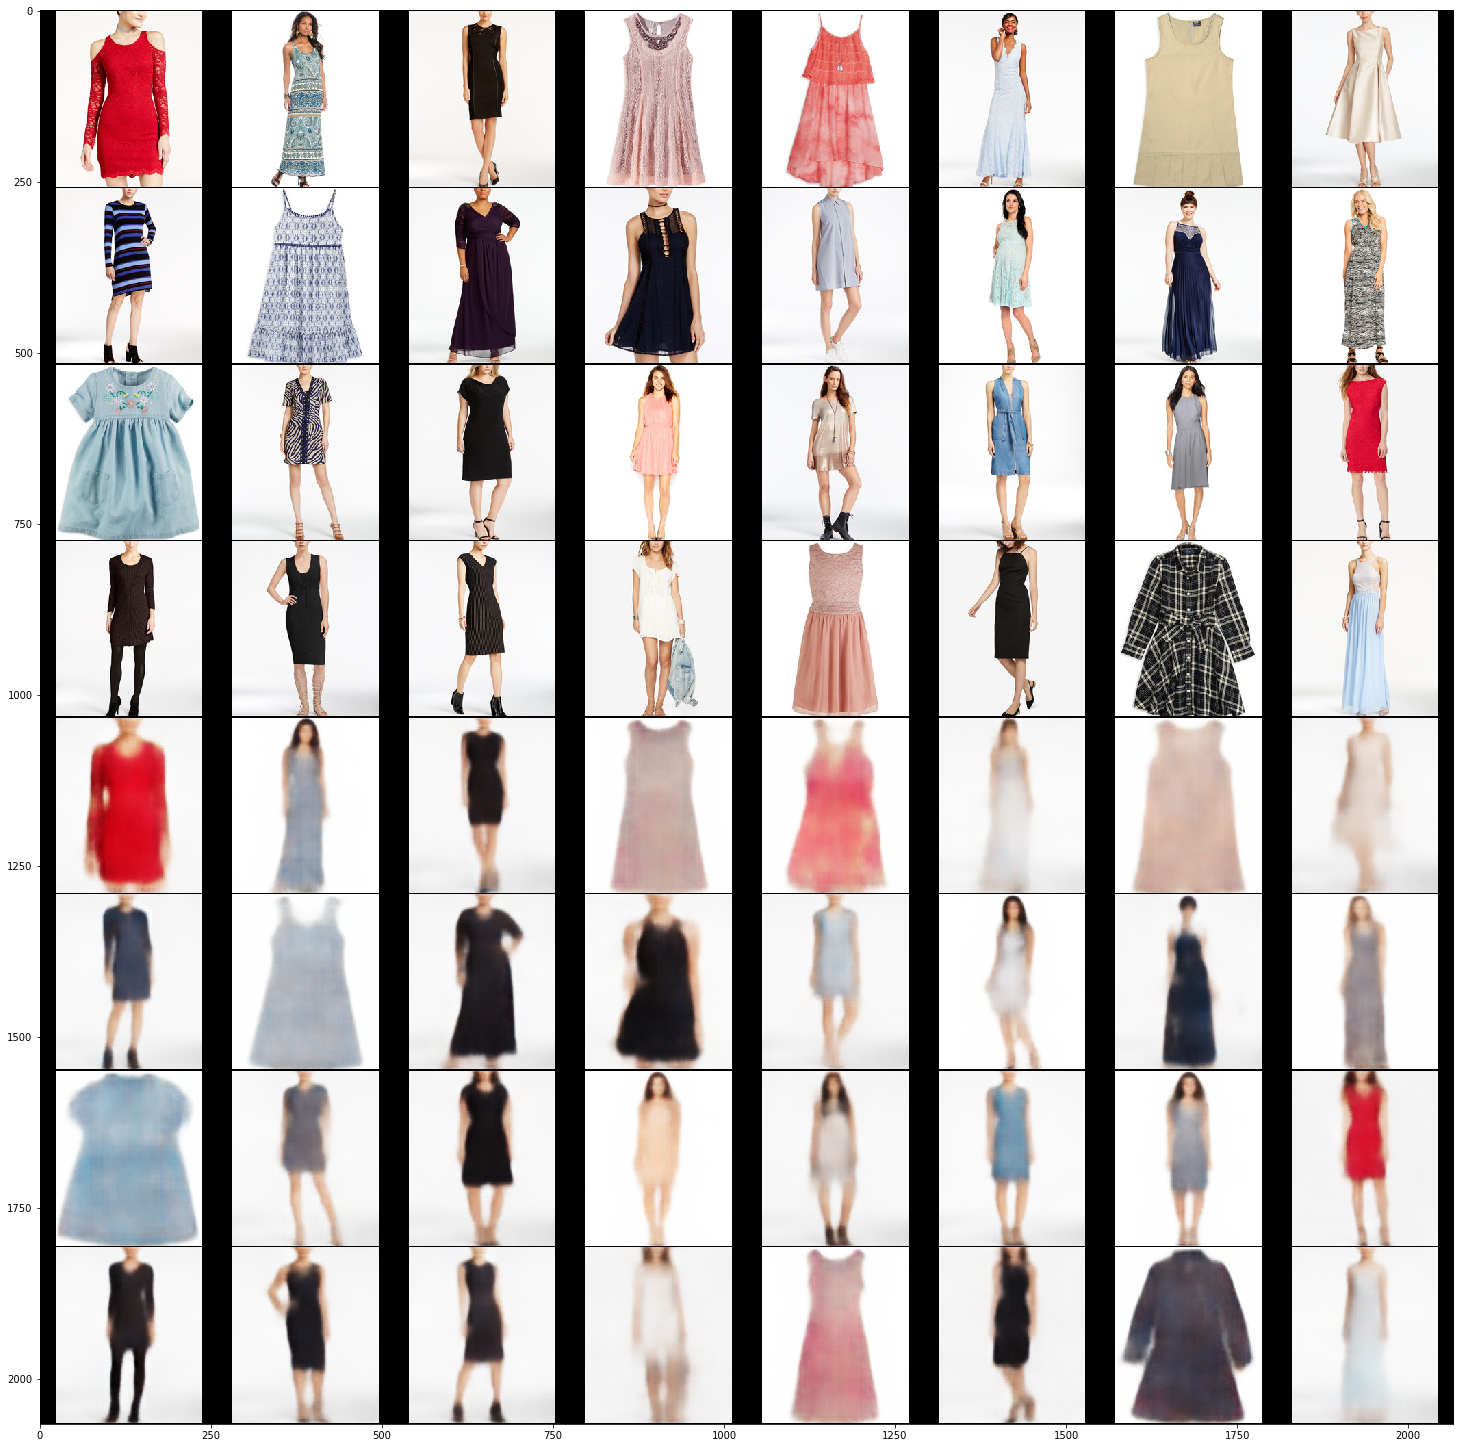

In [25]:
# Plot reconstructions
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get a batch of data
for batch, labels in test_loader:
    break

# Reconstruct data using Joint-VAE model
recon = viz.reconstructions(batch)

plt.figure(figsize=(26,26))
plt.imshow(np.rot90(np.transpose(recon.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/256/cj1_256_e135_b64_c10d10-10-10-10_gam30_reconstructions.png",dpi=200)

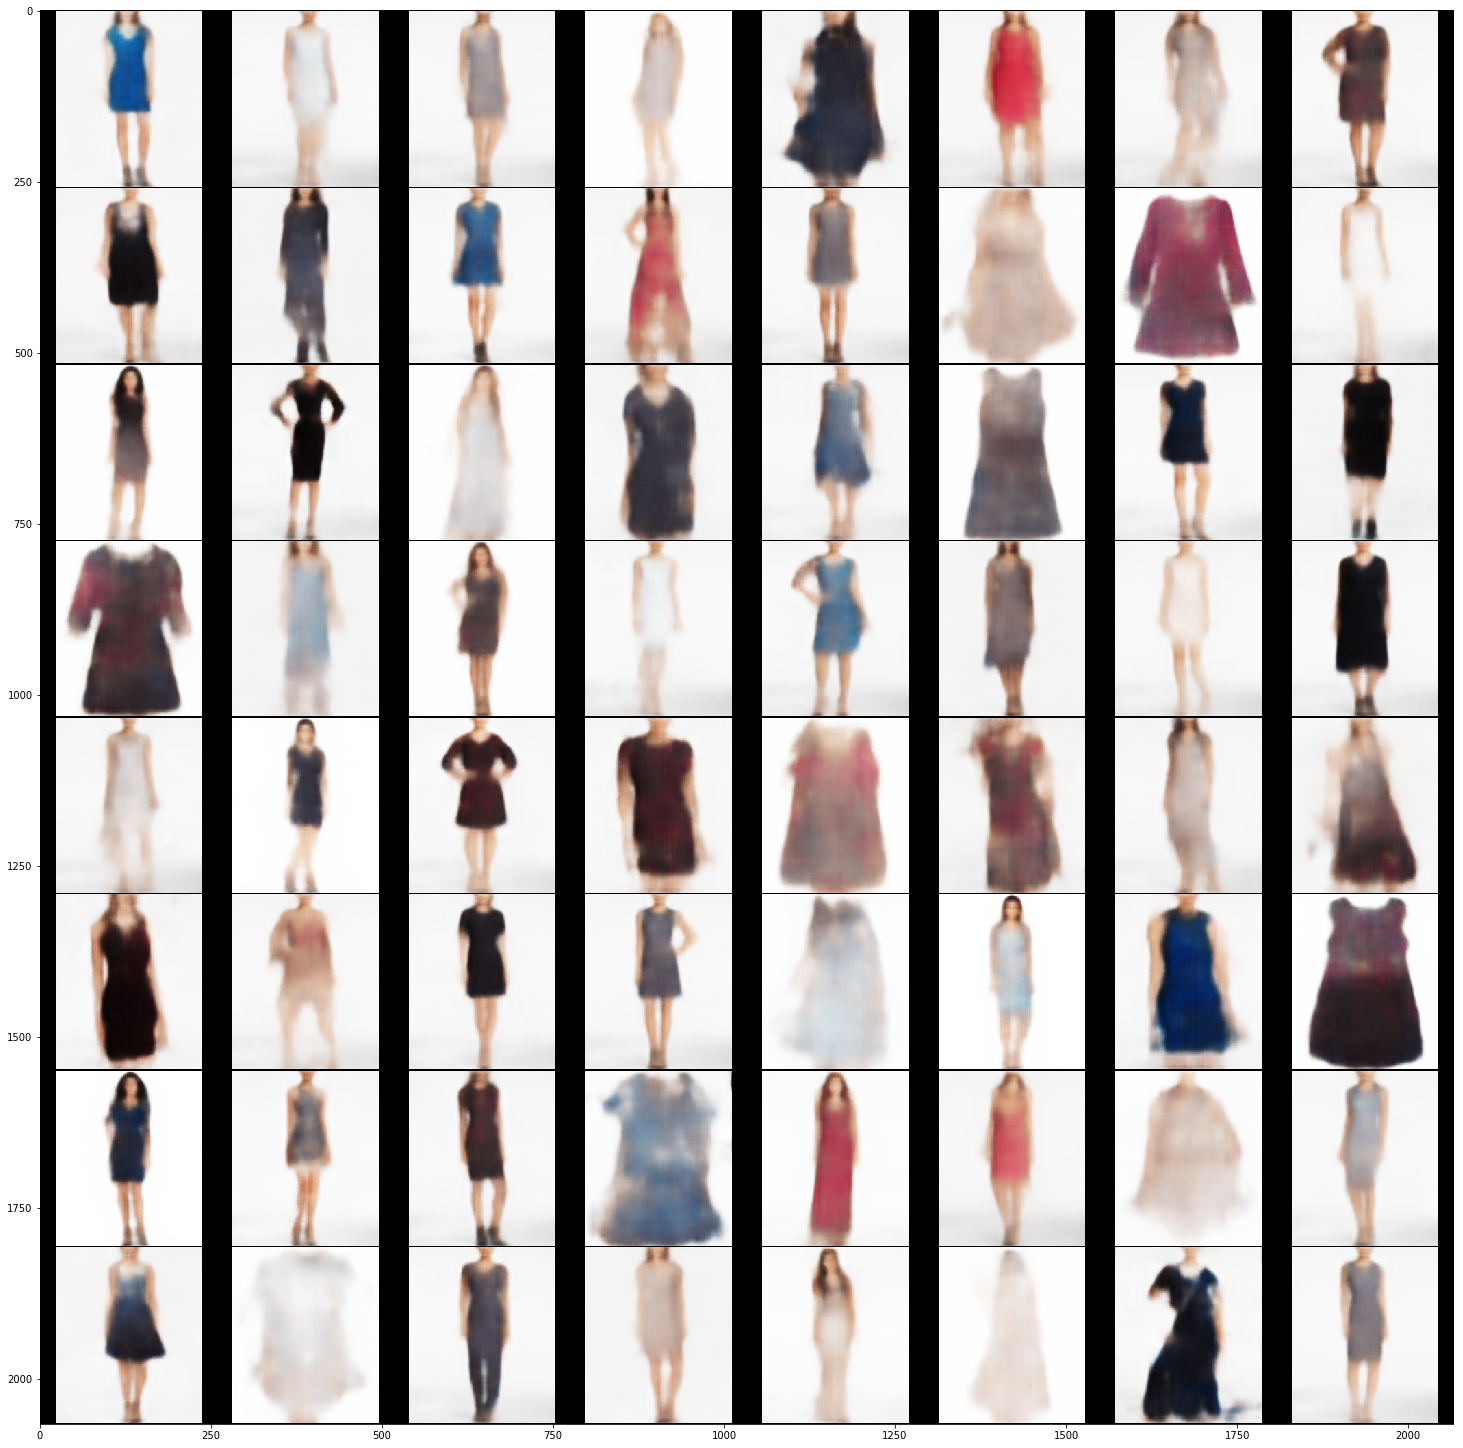

In [26]:
# Plot samples
samples = viz.samples()

plt.figure(figsize=(26,26))
plt.imshow(np.rot90(np.transpose(samples.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/256/cj1_256_e135_b64_c10d10-10-10-10_samples.png",dpi=200)

### Note on Traversals

### Traverses all latent dimensions one by one and plots a grid of images where each row corresponds to a latent traversal of one latent dimension
* size: Number of samples for each latent traversal.

In [76]:
print(viz.model.latent_cont_dim, viz.model.num_disc_latents)

20 3


In [27]:
# Plot all traversals
traversals = viz.all_latent_traversals(size=20)

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/256/cj1_256_e135_b64_c10d10-10-10-10_all_traversals_n20.png",dpi=200)

RuntimeError: CUDA error: out of memory

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/256/cj1_256_e135_b64_c10d10-10-10-10_traversals2100.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=1, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(traversals.numpy()[0, :, :]);
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/256/cj1_256_e135_b64_c10d10-10-10-10_traversals1100.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=9, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/256/cj1_256_e135_b64_c10d10-10-10-10_traversals9100.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=1, disc_idx=0, disc_axis=1, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/256/cj1_256_e135_b64_c10d10-10-10-10_traversals2101.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=0, disc_idx=0, disc_axis=1, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/256/cj1_256_e135_b64_c10d10-10-10-10_traversals2001.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=3, cont_axis=0, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/256/cj1_256_e135_b64_c10d10-10-10-10_traversals3000.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=12, cont_axis=0, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/256/cj1_256_e135_b64_c10d10-10-10-10_traversals3000.png",dpi=200)

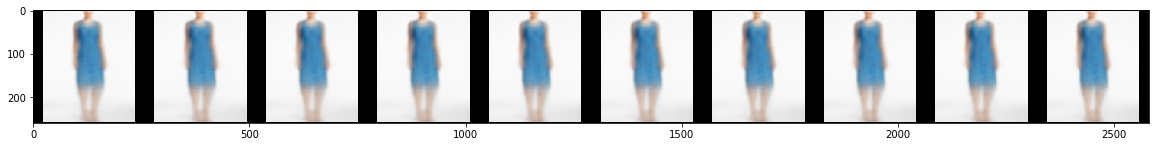

In [93]:
# Plot a grid of some traversals
traversals = viz2.latent_traversal_grid2(cont_idx=3, cont_axis=0, disc_idx=0, disc_axis=0, size=(20, 20),first_n=10)

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
#plt.savefig("sample_images/306/256/cj1_256_e50maybe_b64_c10d10-10-10_gam30_traversals3000.png",dpi=200)

In [1]:
def thing():
    print(hi)

In [3]:
thing.__name__

'thing'

### Save Model

In [ ]:
model_name = "cj1_256_e135_b64_c10d10-10-10-10.pth"

In [ ]:
torch.save(model.state_dict(),"trained_models/" + "statedict_" + model_name) # save state dict
#torch.save(model, model_name) # save full model

In [ ]:
print("Done training: ",model_name)

#### Restore Model from State Dict

In [ ]:
sd_model = VAE(latent_spec=latent_spec, img_size=(3, 64, 64))
sd_model.load_state_dict(torch.load("statedict_" + model_name))

#### Restore Full Model
* Note in this case the serialized data is bound to the specific classes and exact directory strucutre used.

In [ ]:
full_model = torch.load(model_name)

In [ ]:
type(full_model)

In [ ]:
type(sd_model)

In [ ]:
!ls